In [49]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

from datasets import load_dataset
import pandas as pd
from datasets import ClassLabel
import psutil
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm
import numpy as np
from IPython.display import clear_output

import src.model.fasttext as fasttext

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ds = load_dataset("elalber2000/stop-slop-data")["train"]
ds = ds.rename_columns({
    "content": "text",
})

def binarize(example):
    example['label'] = {"Non-Slop": 0, "Slop": 1}[example['slop']]
    return example

ds = ds.map(binarize)

features = ds.features.copy()
features["label"] = ClassLabel(names=["Non-Slop", "Slop"])
ds = ds.cast(features)

In [3]:
splits = ds.train_test_split(
    test_size=0.2,
    stratify_by_column="label",
    seed=42
)
train_ds, val_ds = splits["train"], splits["test"]

In [4]:
# Memory Availability

mem = psutil.virtual_memory()
print(f"Available memory: {mem.available / (1024**2):.2f} MB")
print(f"Total memory: {mem.total / (1024**2):.2f} MB")
print(f"Used memory: {(mem.total - mem.available) / (1024**2):.2f} MB")

Available memory: 260.22 MB
Total memory: 2987.68 MB
Used memory: 2727.46 MB


In [35]:
ft = fasttext.FastText(
    num_class=2,
    lr=0.05,
    ngram_size=3,
    emb_size=100,
    batch_size=32,
    bucket_size=int(5e5),
    dropout_rate=0,
    min_subword_freq=3,
    max_token=200,
)

ft.build_subword_mask(train_ds)

2025-04-26 01:33:50,352 [INFO] Initializing config
2025-04-26 01:33:50,355 [INFO] Initializing parameters
2025-04-26 01:33:52,582 [INFO] Initializing aux stuff
2025-04-26 01:33:52,661 [INFO] Building subword mask


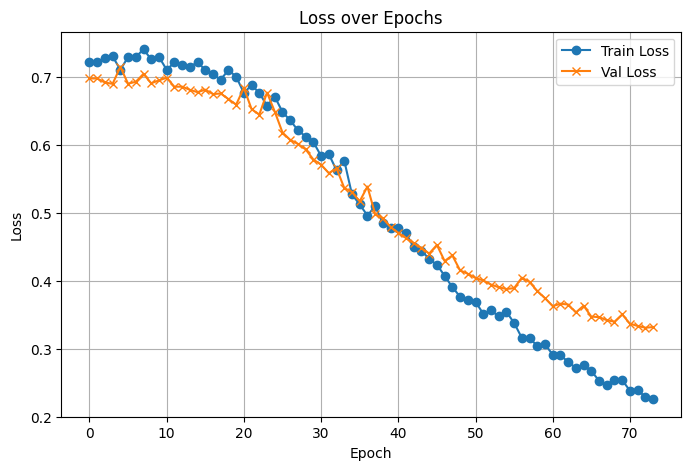

Epoch 74: train=0.2255, val=0.3319


In [36]:
N_EPOCH = 75

train_losses, val_losses = [], []

for epoch in range(1, N_EPOCH):
    train_ds = train_ds.shuffle(seed=epoch)
    epoch_loss = 0.0
    for i in range(0, len(train_ds), ft.batch_size):
        idx = range(i, min(i + ft.batch_size, len(train_ds)))
        batch = train_ds.select(idx)
        df = pd.DataFrame(batch[:])
        ft.backward(df)
        epoch_loss += ft._loss_vals[-1]
    avg_train = epoch_loss / (len(train_ds) / ft.batch_size)
    train_losses.append(avg_train)

    val_df = pd.DataFrame(val_ds[:])
    vloss = ft.eval(val_df)
    val_losses.append(vloss)

    # live plot
    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.plot(train_losses,   marker='o', label='Train Loss')
    plt.plot(val_losses,     marker='x', label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Epoch {epoch:2d}: train={avg_train:.4f}, val={vloss:.4f}")


In [ ]:
ngram_score = defaultdict(float)
ngram_count = defaultdict(int)
grad = ft.weights[:, 0]

for ex in tqdm(train_ds, desc="Impact"):
    for word in ft.tokenize(ex["text"]):
        for ngram in word:
            idx = ft.hash(ngram)
            if not ft.subword_mask[idx]:
                continue
            key = f"{ngram} ({word})"
            emb = ft.vocab[idx]
            ngram_score[key] += np.dot(emb, grad)
            ngram_count[key] += 1

# average impact per occurrence
avg_impact = {
    ng: score / ngram_count[ng]
    for ng, score in ngram_score.items()
}

top100 = sorted(
    avg_impact.items(),
    key=lambda x: -abs(x[1])
)[:100]

for ng, sc in top100:
    print(f"{ng:>15s}: {sc:+.4f}")

Impact: 100%|██████████| 770/770 [00:04<00:00, 182.76it/s]


ers (['<an', 'ans', 'nsw', 'swe', 'wer', 'ers', 'rs>', 'answers']): +50.4802
ers (['<pa', 'par', 'art', 'rtn', 'tne', 'ner', 'ers', 'rs>', 'partners']): +50.4802
ers (['<id', 'ide', 'den', 'ent', 'nti', 'tif', 'ifi', 'fie', 'ier', 'ers', 'rs>', 'identifiers']): +50.4801
ers (['<ot', 'oth', 'the', 'her', 'ers', 'rs>', 'others']): +50.4801
ers (['<ne', 'new', 'ews', 'wsl', 'sle', 'let', 'ett', 'tte', 'ter', 'ers', 'rs>', 'newsletters']): +50.4801
ers (['<bu', 'buy', 'uye', 'yer', 'ers', 'rs>', 'buyers']): +50.4801
ers (['<pe', 'per', 'ers', 'rso', 'son', 'ona', 'nal', 'al>', 'personal']): +50.4801
ers (['<co', 'con', 'onv', 'nve', 'ver', 'ers', 'rsa', 'sat', 'ati', 'tio', 'ion', 'on>', 'conversation']): +50.4801
ers (['<re', 'ret', 'eta', 'tai', 'ail', 'ile', 'ler', 'ers', 'rs>', 'retailers']): +50.4801
ers (['<pe', 'per', 'ers', 'rso', 'son', 'ona', 'nal', 'ali', 'lit', 'ity', 'ty>', 'personality']): +50.4801
ers (['<mo', 'mow', 'owe', 'wer', 'ers', 'rs>', 'mowers']): +50.4801
ers (['<c

In [50]:
tok = fasttext.FastTextTokenizer(
    bucket_size=int(5e5),
    ngram_size=3,
    min_subword_freq=3,
    max_token=200,
)
tok.build_subword_mask([ex["text"] for ex in train_ds])

ft = fasttext.FastText(
    num_class=2,
    lr=0.05,
    emb_size=100,
    batch_size=32,
    bucket_size=int(5e5),
    dropout_rate=0,
)

2025-04-27 13:40:39,976 [INFO] Initializing config
2025-04-27 13:40:39,981 [INFO] Initializing parameters
2025-04-27 13:40:41,791 [INFO] Initializing vals


In [51]:
train_texts = [ex["text"] for ex in train_ds]
train_labels = np.array([ex["label"] for ex in train_ds])
train_tokens = tok.batch_encode(train_texts)

val_texts   = [ex["text"] for ex in val_ds]
val_labels  = np.array([ex["label"] for ex in val_ds])
val_tokens  = tok.batch_encode(val_texts)

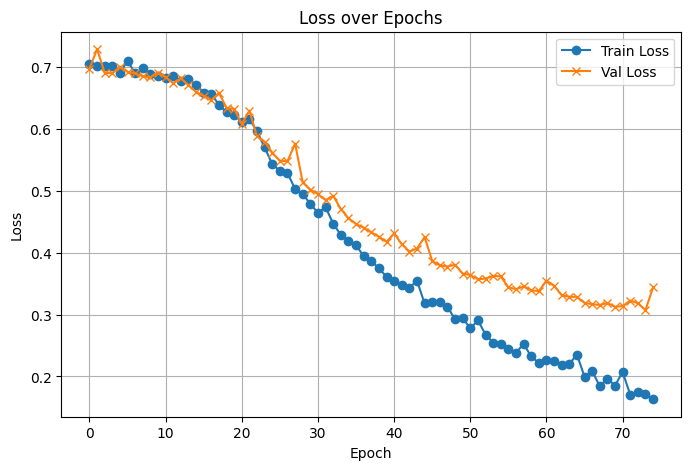

Epoch 75: train=0.1633, val=0.3439


In [52]:
N_EPOCH = 75
train_losses, val_losses = [], []

for epoch in range(1, N_EPOCH + 1):
    perm = np.random.permutation(len(train_tokens))
    epoch_losses = []

    for i in range(0, len(perm), ft.batch_size):
        batch_idx    = perm[i : i + ft.batch_size]
        batch_toks   = [train_tokens[j] for j in batch_idx]
        batch_lbls   = train_labels[batch_idx]
        batch_df     = pd.DataFrame({"text": batch_toks, "label": batch_lbls})

        ft.backward(batch_df)
        epoch_losses.append(ft._loss_vals[-1])

    avg_train = float(np.mean(epoch_losses))
    train_losses.append(avg_train)

    val_df = pd.DataFrame({"text": val_tokens, "label": val_labels})
    vloss  = ft.eval(val_df)
    val_losses.append(vloss)

    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, marker='o', label='Train Loss')
    plt.plot(val_losses,   marker='x', label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Epoch {epoch:2d}: train={avg_train:.4f}, val={vloss:.4f}")

In [ ]:
from collections import defaultdict
from tqdm import tqdm

w_diff = ft.weights[:,1] - ft.weights[:,0]

# accumulate per ngram→word
ngram_scores = defaultdict(lambda: defaultdict(float))
ngram_counts = defaultdict(lambda: defaultdict(int))

for text in tqdm(train_texts, desc="Impact"):
    words      = tok._split(text)
    ngrams_lst = [tok._ngrams(wd) for wd in words]
    ids_lst    = tok.encode(text)

    for word, ngrams, ids in zip(words, ngrams_lst, ids_lst):
        seen = set()
        for ng_str, idx in zip(ngrams, ids):
            if ng_str in seen: continue
            seen.add(ng_str)
            diff = ft.vocab[idx].dot(w_diff)
            key_ng = ng_str if tok.subword_mask[idx] else word
            ngram_scores[key_ng][word] += diff
            ngram_counts[key_ng][word] += 1

# pick the single most impactful word for each ngram
avg_impact = {}
for ng, wd_dict in ngram_scores.items():
    best_w, best_avg = max(
        ((w, s/ngram_counts[ng][w]) for w, s in wd_dict.items()),
        key=lambda x: abs(x[1])
    )
    avg_impact[f"{ng} ({best_w})"] = best_avg

# top 100 by absolute impact
top100 = sorted(avg_impact.items(), key=lambda x: -abs(x[1]))[:100]
for feat, sc in top100:
    print(f"{feat:>25s}: {sc:+.4f}")

Impact:  35%|███▌      | 273/770 [00:02<00:05, 96.80it/s] 